In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.4MB/s 
     |████████████████████████████████| 2.1MB 30.2MB/s 
     |████████████████████████████████| 9.5MB 40.7MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Occupancy analysis with `pmdarima`



In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import pmdarima as pm
print(f"Using pmdarima {pm.__version__}")

Using pmdarima 1.8.0


### Import the data



In [4]:
!git clone https://github.com/valwork2021/Hackathon.git

Cloning into 'Hackathon'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 53 (delta 19), reused 23 (delta 2), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [5]:
fileName = "serraview_wallSt_by_team_allocation_sensor_activity_by_hour-2021-03-10T1656.csv"
df_original = pd.read_csv('/content/Hackathon/data/' + fileName)
df_original

,Sensor Activity By Hour Start of Hour Time,Sensor Activity By Hour Minutes,Sensor Activity By Hour Minutes.1,Sensor Activity By Hour Minutes.2,Sensor Activity By Hour Minutes.3,Sensor Activity By Hour Minutes.4,Sensor Activity By Hour Minutes.5,Sensor Activity By Hour Minutes.6,Sensor Activity By Hour Minutes.7,Sensor Activity By Hour Minutes.8,Sensor Activity By Hour Minutes.9,Sensor Activity By Hour Minutes.10,Sensor Activity By Hour Minutes.11,Sensor Activity By Hour Minutes.12,Sensor Activity By Hour Minutes.13,Sensor Activity By Hour Minutes.14,Sensor Activity By Hour Minutes.15,Sensor Activity By Hour Minutes.16,Sensor Activity By Hour Minutes.17,Sensor Activity By Hour Minutes.18
0,2019-10-01 11:00:00,NaN,60.0,NaN,540.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,941.0
1,2019-10-01 12:00:00,NaN,60.0,NaN,540.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,955.0
2,2019-10-01 13:00:00,NaN,60.0,NaN,540.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,960.0
3,2019-10-01 14:00:00,NaN,60.0,NaN,540.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,960.0
4,2019-10-01 15:00:00,NaN,60.0,NaN,540.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6945,2020-08-11 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0
6946,2020-08-11 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.0
6947,2020-08-11 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0
6948,2020-08-11 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.0


In [6]:
df = pd.DataFrame()
df = df_original.iloc[1:, 4].astype(float)
df.fillna(0, inplace=True)

df

1       540.0
2       540.0
3       540.0
4       540.0
5       540.0
        ...  
6945      0.0
6946      0.0
6947      0.0
6948      0.0
6949      0.0
Name: Sensor Activity By Hour Minutes.3, Length: 6949, dtype: float64

### Split the data

We'll use 80% of the samples as training data. Note that a time series' train/test split is different from that of a dataset without temporality; order *must* be preserved if we hope to discover any notable trends.

In [7]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = df[:train_len], df[train_len:]

y_train = train_data.values
y_test = test_data.values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

5559 train samples
1390 test samples


### Pre-modeling analysis



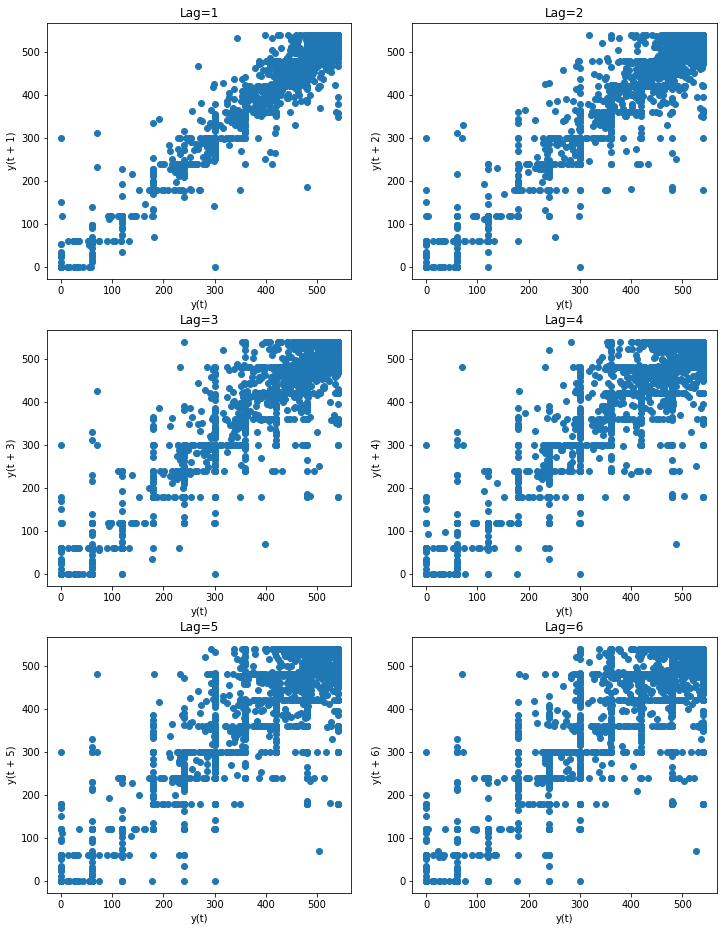

In [8]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(12, 16))
plt.title('Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df, lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")
    
plt.show()

### Estimating the differencing term

We can estimate the best lag term with several statistical tests:

In [9]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


Use `auto_arima` to fit a model on the data.

In [10]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=True, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=49376.217, Time=6.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49380.885, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49374.053, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49374.316, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49379.010, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=49374.977, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=49375.452, Time=0.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=49376.347, Time=5.41 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=49372.167, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=49373.089, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=49373.558, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=49372.431, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=49374.456, Time=2.43 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 17.561 seconds


In [11]:
print(auto.order)

(1, 1, 0)


In [12]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    
    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)
    
print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 9.936516487859993
SMAPE: nan


/usr/local/lib/python3.7/dist-packages/pmdarima/metrics.py:51: RuntimeWarning: invalid value encountered in true_divide
  return np.mean((abs_diff * 200 / (np.abs(y_pred) + np.abs(y_true))))


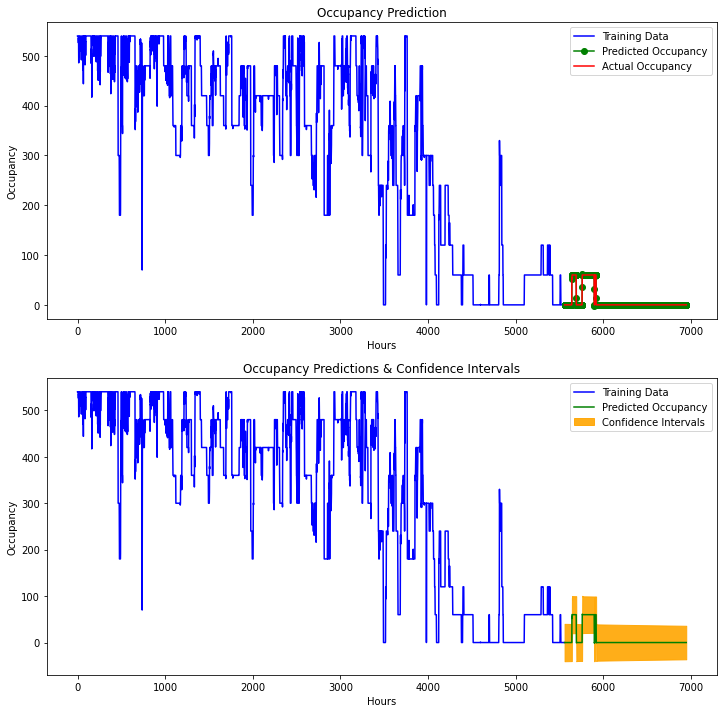

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Occupancy')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Occupancy')
axes[0].set_title('Occupancy Prediction')
axes[0].set_xlabel('Hours')
axes[0].set_ylabel('Occupancy')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Occupancy')

axes[1].set_title('Occupancy Predictions & Confidence Intervals')
axes[1].set_xlabel('Hours')
axes[1].set_ylabel('Occupancy')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")
axes[1].legend()